<h1> <a href=http://www.datascience-paris-saclay.fr/>Paris Saclay Center for Data Science</a> </h1>

<h2> RAMP on charged particle tracking in 2D with a possible future LHC Silicon detector </h2>

<i> Thomas Boser (CHALEARN), Mikhail Hushchyn (YSDA/Russia), Balázs Kégl (LAL/Orsay), David Rousseau (LAL/Orsay), Yetkin Yılmaz (LAL/Orsay) </i>

<h2> Introduction </h2>

<p> 

<p>The main objective is to achive the optimal assignment of each hit to a track id.



### Requirements

* numpy>=1.10.0  
* matplotlib>=1.5.0 
* pandas>=0.17.0  
* scikit-learn>=0.17 (different syntaxes for v0.17 and v0.18)  

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Exploratory data analysis

### Loading the data

In [3]:
filename = "public_train.csv"
df = pd.read_csv(filename)

The data consists of the following columns:
event, particle, layer, iphi, x, y

In [4]:
df

,event,particle_id,layer,iphi,x,y
0,0,1,6,67181,535.840039,-169.468147
1,0,2,7,22631,65.319563,759.195202
2,0,4,1,8368,-66.070384,53.476203
3,0,1,7,91140,727.313411,-227.286608
4,0,2,4,16216,20.268475,270.240983
5,0,3,2,37015,147.466204,-47.735927
6,0,6,0,5132,-38.573229,-5.753784
7,0,9,3,4338,185.982644,103.824160
8,0,9,8,10655,861.414226,507.903073
9,0,9,5,4177,352.333427,199.715188


In [4]:
y = df.drop(['layer','iphi','x','y'], axis=1).values
X = df.drop(['particle'], axis=1).values

(particle ids are shifted by 1000 times the event id, in order to make them unique across the dataset)

In [5]:
len(X)

92023

### Looping over events

In [6]:
y_events = y[:,1]

In [7]:
events = np.unique(y_events)

### Visualize the hits in a single event

In [8]:
ievent = 1
event_indices = X[:,4]==ievent
X_event = X[event_indices]
pixelx = X_event[:,2]
pixely = X_event[:,3]
particles = y[event_indices][:,0]

#### Hits from all particles

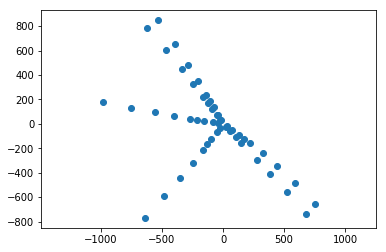

In [9]:
plt.scatter(pixelx,pixely)
plt.axis('equal')
plt.show()

This is what the algorithm will see.

#### Hits from a single particle

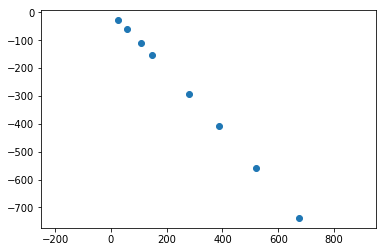

In [10]:
iparticle = 2
iparticle += ievent
hits_particle = (particles == iparticle)
plt.scatter(pixelx[hits_particle],pixely[hits_particle])
plt.axis('equal')
plt.show()

So, ideally, our algorithm wants to assign specific ids to all hits in a way that corresponds to the particle. The perfect algorithm will split the event into various tracks:

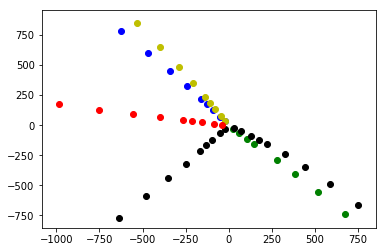

In [11]:
cmap = ['k','b','y','g','r','k','b']
for iparticle in np.unique(particles):
    hits_particle = (particles == iparticle)
    plt.scatter(pixelx[hits_particle],pixely[hits_particle],color=cmap[int(iparticle) % 7])
plt.show()

### Matching the hits together

In [12]:
#import Hough
#import NearestHit
#import LinearApproximation

In [13]:
coleventX = 4
class NearestHit(object):

    def __init__(self, min_cos_value=0.9):
        self.min_cos_value = min_cos_value

    def fit(self, X, y):
        pass

    def predict_one_event(self, X):
        x, y, layers = X[:, 2], X[:, 3], X[:, 0]
        used = np.zeros(len(x))
        labels = -1. * np.ones(len(x))
        track_id = 0

        # Start from a hit in the first layer
        for first_id in np.arange(0, len(x))[layers == 0]:

            track = []
            track += [first_id]
            used[first_id] = 1

            # Go through other detector layers
            for one_layer in np.unique(layers)[1:]:

                # Select hits of the layer
                hit_ids = np.arange(0, len(x))[(layers == one_layer)*(used == 0)]

                # Compute distance between hits
                diff_r = (x[track[-1]] - x[hit_ids])**2 + (y[track[-1]] - y[hit_ids])**2

                if len(diff_r) == 0:
                    break

                # Select new track hit
                track_hit_id = hit_ids[diff_r == diff_r.min()][0]

                # Check cos of angle between two track segments
                if one_layer != 1:

                    x1, x2, x3 = x[track[-2]],  x[track[-1]], x[track_hit_id]
                    y1, y2, y3 = y[track[-2]],  y[track[-1]], y[track_hit_id]
                    dx1, dx2 = x2 - x1, x3 - x2
                    dy1, dy2 = y2 - y1, y3 - y2

                    cos = (dx1*dx2 + dy1*dy2) / np.sqrt((dx1**2 + dy1**2) * (dx2**2 + dy2**2))

                    if cos < self.min_cos_value:
                        break

                # Add new hit to the track
                track += [track_hit_id]
                used[track_hit_id] = 1

            # Label the track hits
            labels[track] = track_id
            track_id += 1


        return labels

    def predict(self, X):
        event_ids = np.unique(X[:, coleventX])
        labels = []

        for one_event_id in event_ids:

            X_event = X[X[:, coleventX] == one_event_id]
            labels_event = self.predict_one_event(X_event)
            labels += list(labels_event)

        return np.array(labels)


Choose the tracking class that you want to use
(in the submission, it has to be named HitToTrackAssignment in Tracking.py)

In [14]:
tracker = NearestHit()
#tracker = LinearApproximation.LinearApproximation(min_hits=4, window_width=0.03)
#tracker = Hough.Hough(n_theta_bins=5000, n_radius_bins=1000, min_radius=20., min_hits=4)

#### Training the algorithm

In [15]:
tracker.fit(X, y)

#### Running the algorithm to reconstruct the tracks in data
This will take some time to go through all events

In [16]:
y_true = y
y_predicted = tracker.predict(X)

Let's compare how well the tracks corresponds to the particles

In [26]:
df_result = pd.DataFrame({'particle':y_true[event_indices,0],'track':y_predicted[event_indices]}).sort('particle')
df_result

,particle,track
0,0,5
50,0,5
47,0,5
43,0,5
7,0,5
10,0,5
11,0,5
32,0,5
23,0,5
49,1,4


In [30]:
tracks = y_predicted[event_indices]

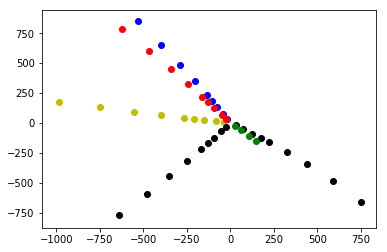

In [31]:
cmap = ['k','b','y','g','r']
for itrack in np.unique(tracks):
    if itrack >= 0:
        hits_track = (tracks == itrack)
        plt.scatter(pixelx[hits_track],pixely[hits_track],color=cmap[int(itrack) % 5])
plt.show()

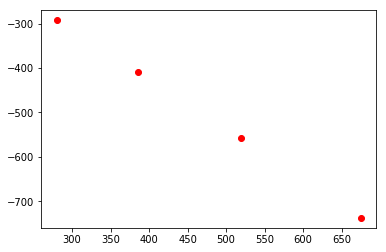

In [32]:
cmap = ['k','b','y','g','r']
itrack = -1
hits_track = (tracks == itrack)
plt.scatter(pixelx[hits_track],pixely[hits_track],color=cmap[int(itrack) % 5])
plt.show()

### Scoring the assignment

The score function measures the fraction of hits with good track assignment

In [33]:
def score(y_test, y_pred):

    total_score = 0.
    y_events = y_test[:,1]
    y_test = y_test[:,0]
    y_pred = y_pred[:,0]

    events = np.unique(y_events)
    for ievent in events:
        eff_total = 0.
        event_indices=(y_events==ievent)
        y_test_event = y_test[event_indices]
        y_pred_event = y_pred[event_indices]

        particles = np.unique(y_test_event)
        npart = len(particles)
        nhit = len(y_test_event)
        dummyarray = np.full(shape=nhit + 1,fill_value=-1, dtype='int64')

        assignedtrack = np.full(shape=npart,fill_value=-1, dtype='int64')
        hitintrack = np.full(shape=npart,fill_value=0, dtype='int64')
        eff = np.full(shape=npart,fill_value=0.)
        con = np.full(shape=npart,fill_value=0.)

        # assign tracks to particles
        ipart = 0
        for particle in particles:
            
            eff[ipart] = 0.
            con[ipart] = 0.

            true_hits = y_test_event[y_test_event[:] == particle]
            found_hits = y_pred_event[y_test_event[:] == particle]

            nsubcluster=len(np.unique(found_hits[found_hits[:] >= 0]))

            if(nsubcluster > 0):
                b=np.bincount((found_hits[found_hits[:] >= 0]).astype(dtype='int64'))
                a=np.argmax(b)

                maxcluster = a

                assignedtrack[ipart]=maxcluster
                hitintrack[ipart]=len(found_hits[found_hits[:] == maxcluster])

            ipart += 1


        # resolve duplicates and count good assignments
        ipart = 0
        sorted=np.argsort(hitintrack)
        hitintrack=hitintrack[sorted]
        assignedtrack=assignedtrack[sorted]
        #    print hitintrack
        for particle in particles:
            itrack=assignedtrack[ipart]
            if((itrack < 0) | (len(assignedtrack[assignedtrack[:] == itrack])>1)):
                hitintrack = np.delete(hitintrack,ipart)
                assignedtrack = np.delete(assignedtrack,ipart)
            else:
                ipart += 1
        ngood = 0.
        ngood = np.sum(hitintrack)
        eff_total = eff_total + (float(ngood) / float(nhit))
        # remove combinatorials
#        print npart, nhit, eff_total
  
        total_score += eff_total


    total_score /= len(y_events)


    return eff_total


In [34]:
len(y_events)

92023

In [36]:
y_test = np.zeros((len(y_events),2))
y_pred = np.zeros((len(y_events),2))

y_test = y_true

y_pred[:,1] = y_events
y_pred[:,0] = y_predicted

score(y_test,y_pred)

0.9080459770114943

In [39]:
score(y_test[y_test[:,1]==ievent],y_pred[y_test[:,1]==ievent])

0.9245283018867925

### Fitting the tracks (beyond the challenge)